https://github.com/raghakot/keras-vis

In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

model = VGG16(weights='imagenet')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
from vis.utils import utils

layer_idx = utils.find_layer_idx(model, 'predictions')
layer_idx

22

In [4]:
from keras import activations

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
import glob

images = glob.glob('img/*.jpg')
images

['img/lion.jpg',
 'img/dog.jpg',
 'img/panda.jpg',
 'img/cat.jpg',
 'img/tiger.jpg',
 'img/koala.jpg']

In [6]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Attention on VGGNet (Saliency)
https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/attention.ipynb

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


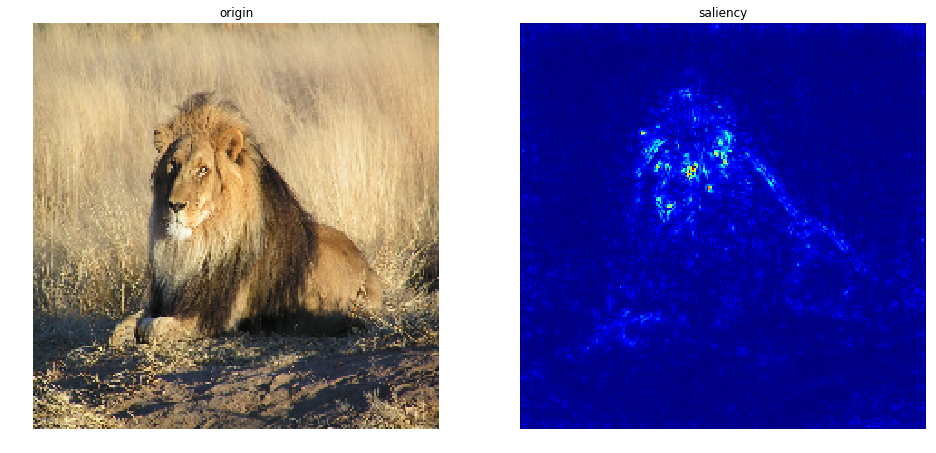

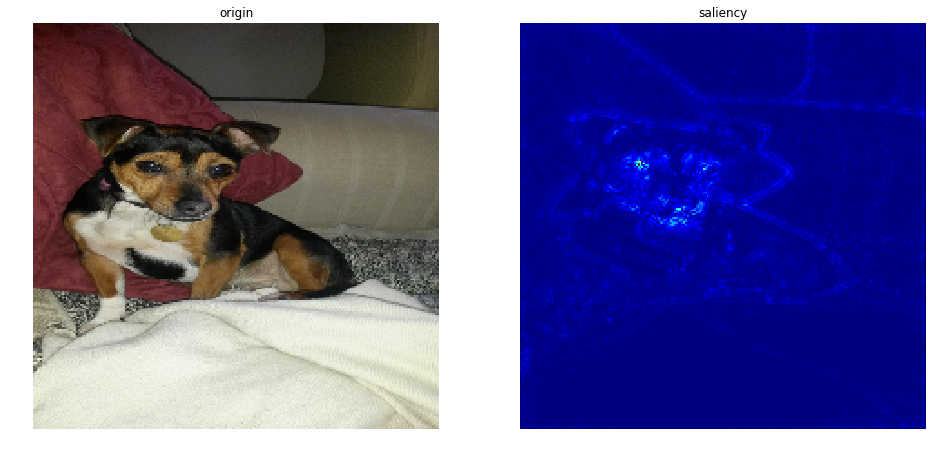

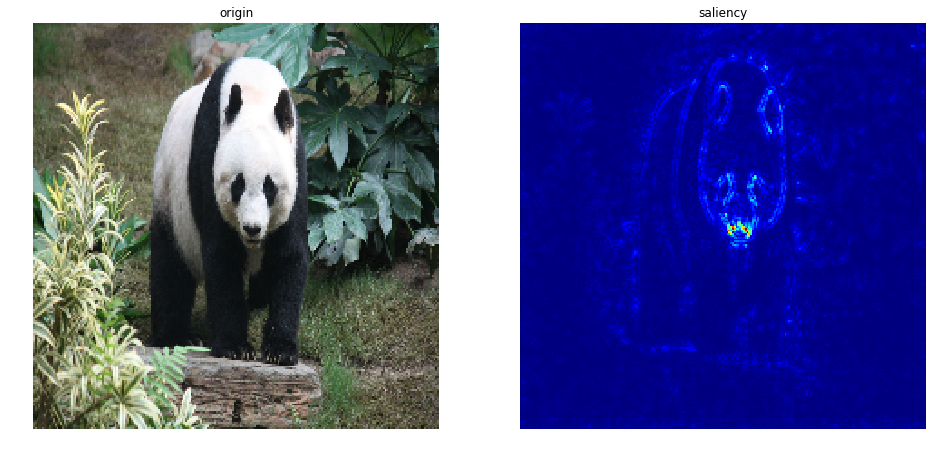

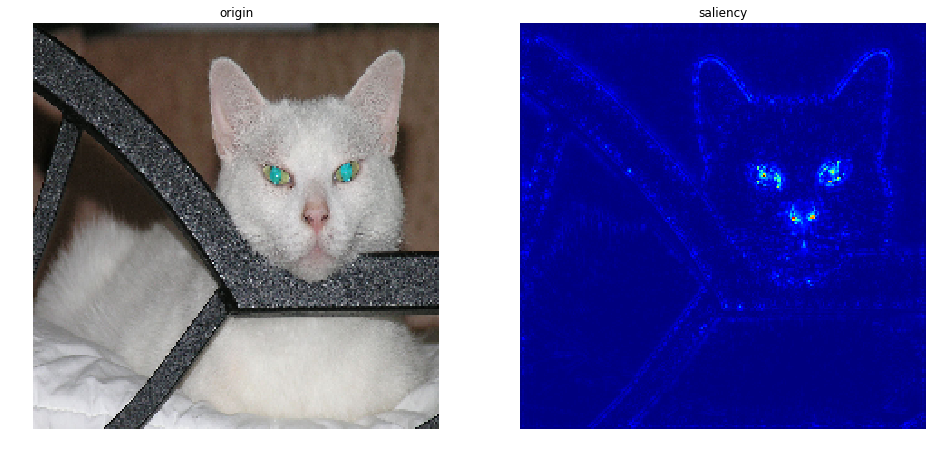

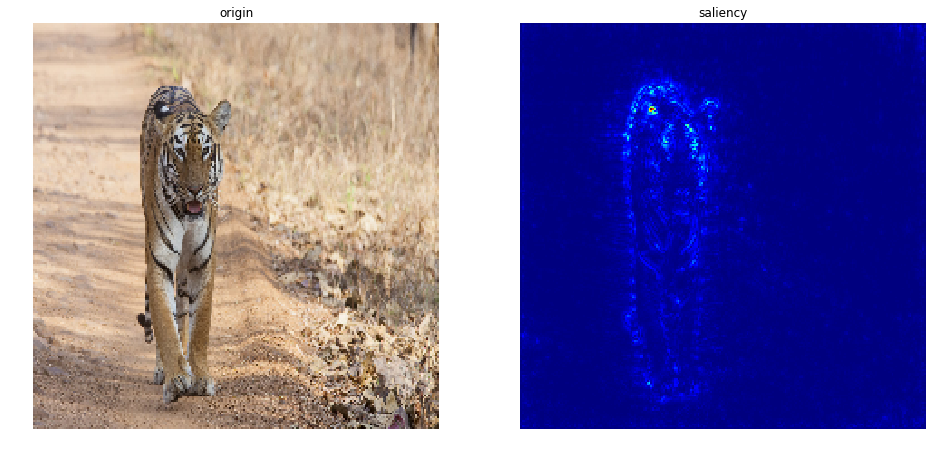

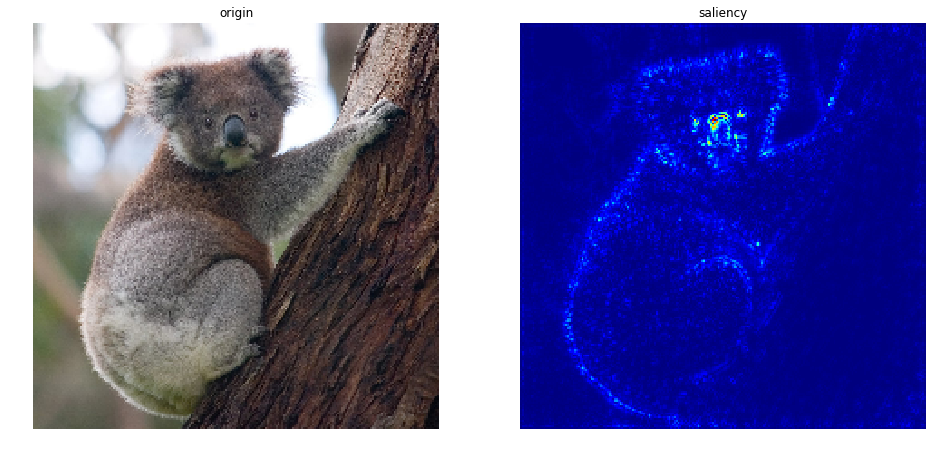

In [7]:
from vis.visualization import visualize_saliency

for img_path in images:
    img = utils.load_img(img_path, target_size=(224, 224))
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    pred_class = np.argmax(model.predict(x))
    
    grads = visualize_saliency(model, layer_idx, filter_indices=pred_class, 
        seed_input=img, backprop_modifier='guided')

    plt.figure()
    f, ax = plt.subplots(1, 2, figsize = (16, 8))
    ax[0].imshow(img)
    ax[0].set_title('origin')
    ax[0].axis('off')
    ax[1].imshow(grads, cmap='jet')
    ax[1].set_title('saliency')
    ax[1].axis('off')
    
    plt.savefig('saliency/%s.jpg' % decode_predictions(model.predict(x), top=1)[0][0][1])

## Attention on VGGNet (grad-CAM)
https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/attention.ipynb

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


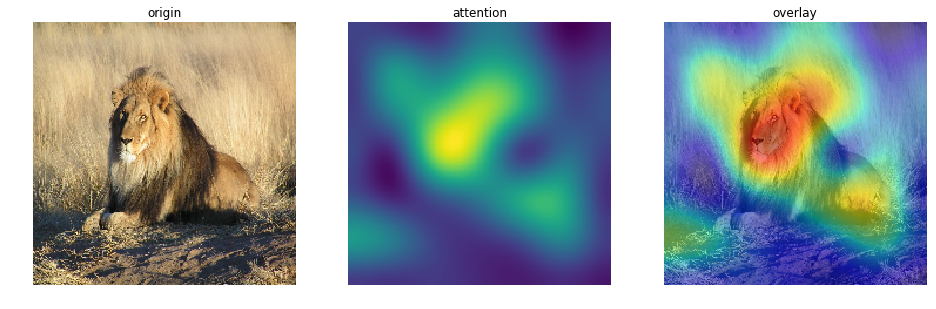

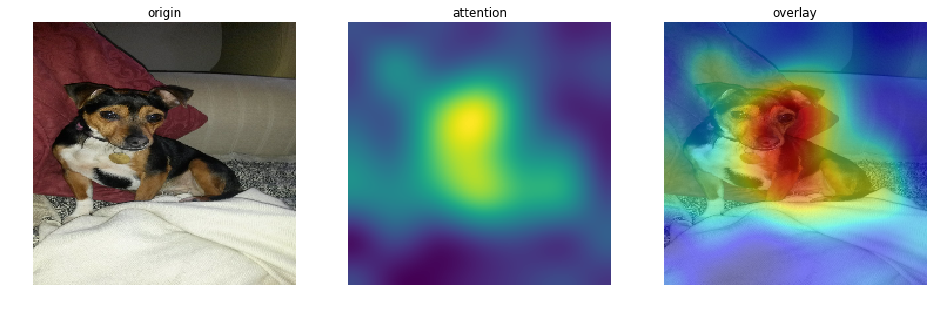

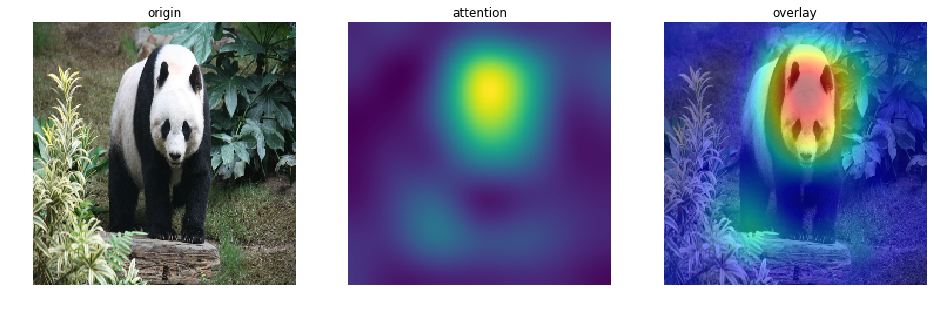

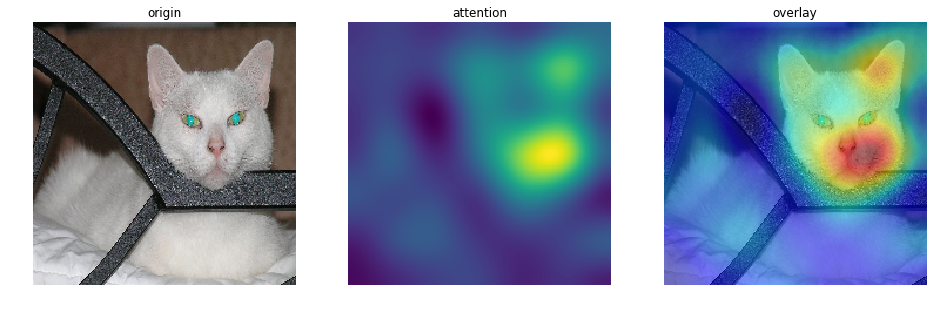

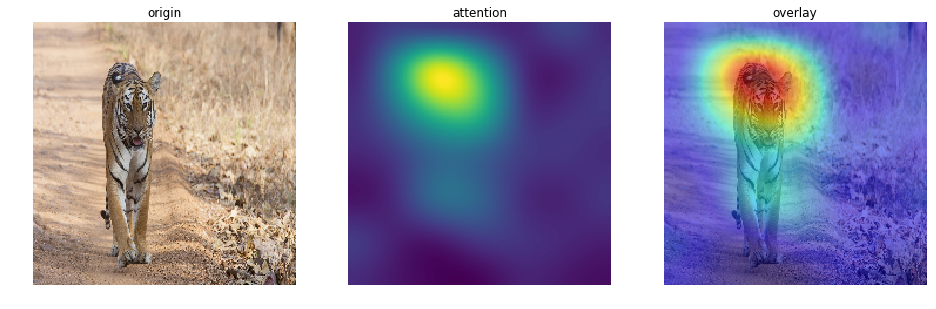

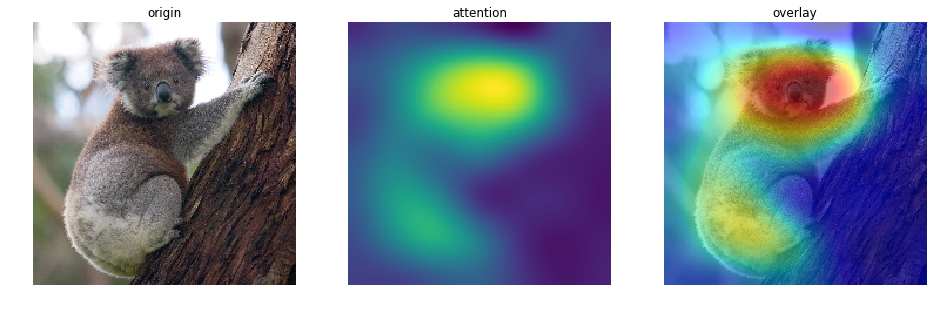

In [8]:
from vis.visualization import visualize_cam, overlay

for img_path in images:
    img = utils.load_img(img_path, target_size=(224, 224))
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    pred_class = np.argmax(model.predict(x))
    
    grads = visualize_cam(model, layer_idx, filter_indices=pred_class, 
        seed_input=img, backprop_modifier='guided')
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

    plt.figure()
    f, ax = plt.subplots(1, 3, figsize = (16, 8))
    ax[0].imshow(img)
    ax[0].set_title('origin')
    ax[0].axis('off')
    ax[1].imshow(grads)
    ax[1].set_title('attention')
    ax[1].axis('off')
    ax[2].imshow(overlay(jet_heatmap, img))
    ax[2].set_title('overlay')
    ax[2].axis('off')
    
    plt.savefig('cam/%s.jpg' % decode_predictions(model.predict(x), top=1)[0][0][1])

## Activation Maximization on VGGNet
https://github.com/raghakot/keras-vis/blob/master/examples/vggnet/activation_maximization.ipynb

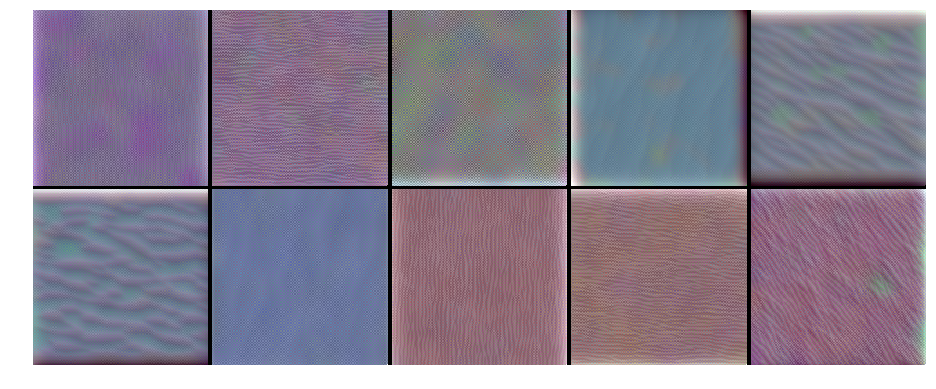

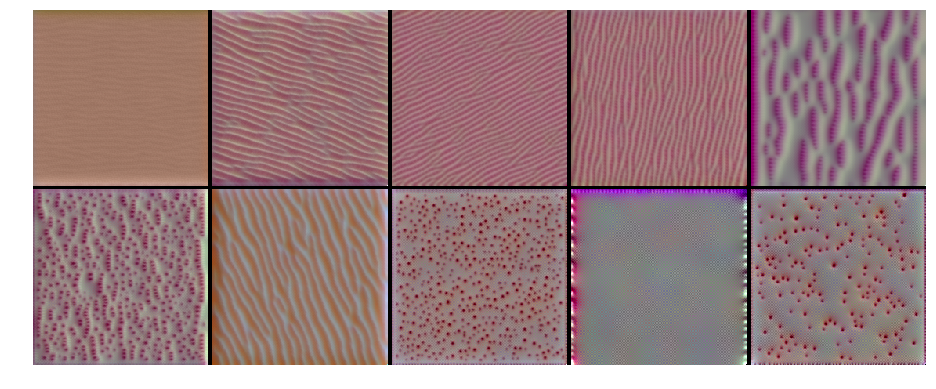

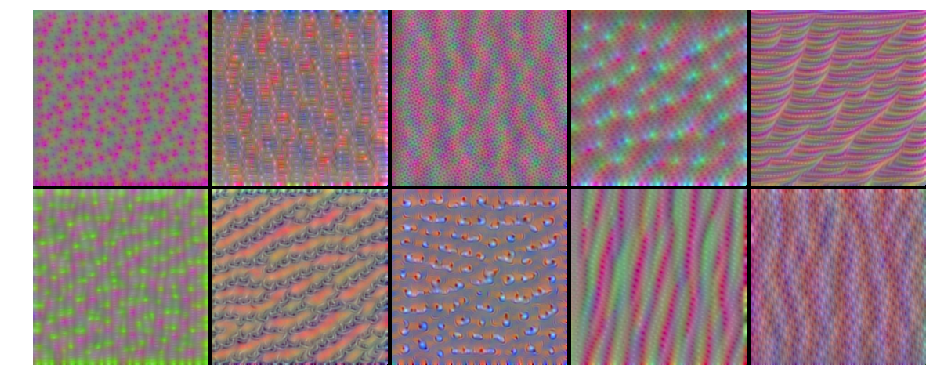

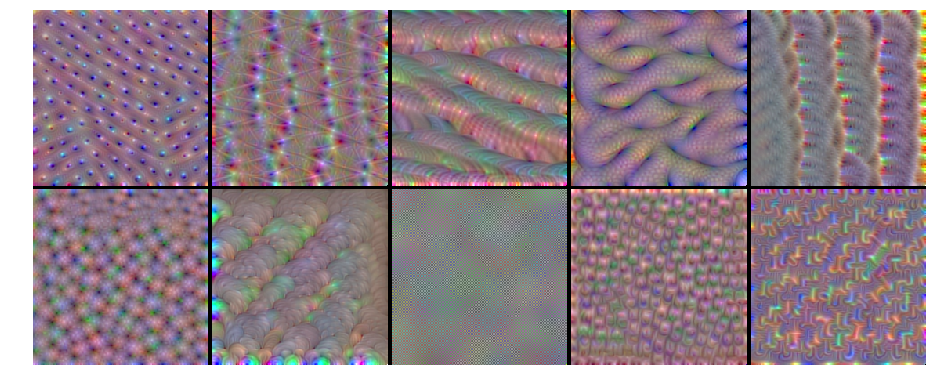

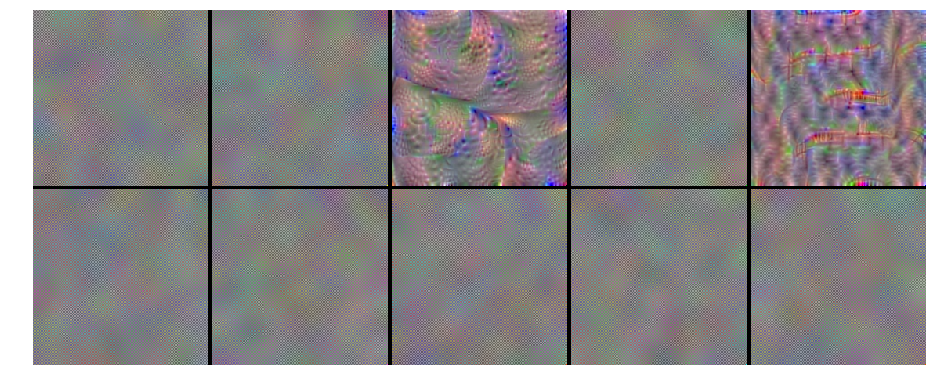

In [9]:
from vis.visualization import visualize_activation, get_num_filters

for layer_name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx)
 
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure(figsize = (16, 8))
    plt.imshow(stitched)
    plt.axis('off')
    plt.savefig('activation/%s.jpg' % layer_name)